In [1]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-n5817b4x
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-n5817b4x
  Resolved https://github.com/huggingface/transformers.git to commit ebccb09169f42ef0d1e508b47d1ca8227ab4b019
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.39.0.dev0-py3-none-any.whl size=8649750 sha256=37c0924f7a292c5253c9a1f323a29579043ebf028f57c63a1203541a94ab23ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-kk22upas/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


In [2]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import os
import cv2
import random
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/ERASMUS/codes/ddmp/atlantis.zip

Archive:  /content/drive/MyDrive/ERASMUS/codes/ddmp/atlantis.zip
   creating: atlantis/depth/
  inflating: atlantis/depth/00022_00193_outdoor_000_000.png  
  inflating: atlantis/depth/00022_00193_outdoor_010_010.png  
  inflating: atlantis/depth/00022_00193_outdoor_020_000.png  
  inflating: atlantis/depth/00022_00193_outdoor_030_020.png  
  inflating: atlantis/depth/00022_00193_outdoor_040_000.png  
  inflating: atlantis/depth/00022_00193_outdoor_050_010.png  
  inflating: atlantis/depth/00022_00193_outdoor_050_030.png  
  inflating: atlantis/depth/00022_00193_outdoor_060_000.png  
  inflating: atlantis/depth/00022_00193_outdoor_060_020.png  
  inflating: atlantis/depth/00022_00193_outdoor_070_010.png  
  inflating: atlantis/depth/00022_00193_outdoor_070_030.png  
  inflating: atlantis/depth/00022_00193_outdoor_080_040.png  
  inflating: atlantis/depth/00022_00193_outdoor_090_000.png  
  inflating: atlantis/depth/00022_00193_outdoor_100_050.png  
  inflating: atlantis/depth/00022_0019

In [5]:
def print_random_images(directory_path, k, rows, cols):
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select k random images
    selected_images = image_files[:k]

    # Create a grid to display the images
    fig, axes = plt.subplots(rows, cols, figsize=(rows*5, cols*2))

    # Loop through the grid and plot images
    for i in range(rows):
        for j in range(cols):
            # If there are no more images to display, break out of the loop
            if not selected_images:
                break
            # Load and display the image
            img_path = os.path.join(directory_path, selected_images.pop())
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(os.path.basename(img_path))

    # Show the plot
    plt.show()

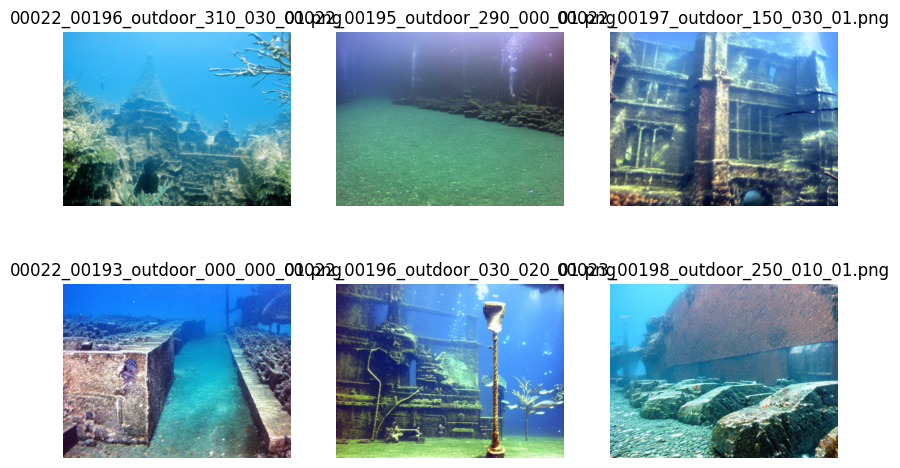

In [6]:
print_random_images('/content/atlantis/img_sorted/01', k=6, rows=2, cols=3)

# Importing DepthAnything and apply to ATLANTIS

In [81]:
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

In [82]:
def depth_estimation(directory_path, k, model, image_processor):
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select k random images
    selected_images = image_files[:k]

    # Create a grid to display the images
    fig, axes = plt.subplots(k, 2, figsize=(10, 2*k))

    for i, img_file in enumerate(selected_images):
        # Load the original image
        img_path = os.path.join(directory_path, img_file)
        original_image = Image.open(img_path)

        # Prepare image for the model
        inputs = image_processor(images=original_image, return_tensors="pt")

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=original_image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )

        # Convert depth prediction to numpy array
        depth_output = prediction.squeeze().cpu().numpy()

        # Plot original image
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image{i}',)

        # Plot depth output
        axes[i, 1].imshow(depth_output,cmap = 'plasma')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Depth{i}')

    plt.show()

#depth_estimation('/content/data_atlantis_sample00/image', k=10, model=model, image_processor=image_processor)


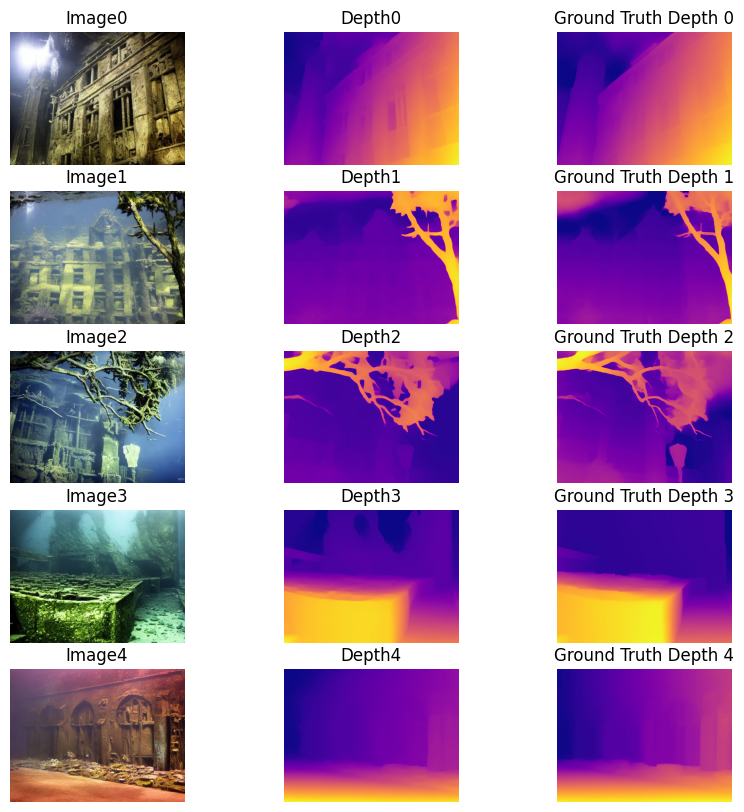

In [83]:
def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image


def depth_estimation_seaThru(directory_path, k, model, image_processor,lighting_type = '00'):
    # Get a list of all files in the directory
    dir_path = os.path.join(directory_path,'img_sorted', lighting_type)
    files = os.listdir(dir_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp','.tiff'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select k random images
    selected_images = image_files[:k]

    # Create a grid to display the images
    fig, axes = plt.subplots(k, 3, figsize=(10, 2*k))

    for i, img_file in enumerate(selected_images):
        # Load the original image
        img_path = os.path.join(directory_path,'img_sorted',lighting_type, img_file)
        assert os.path.exists(img_path)

        original_image = Image.open(img_path)
        original_image_display = cv2.imread(img_path)

        img_lab = cv2.cvtColor(original_image_display,cv2.COLOR_BGR2Lab)
        l,a,b = cv2.split(img_lab)

        clahe = cv2.createCLAHE(clipLimit=50, tileGridSize=(8, 8))
        lumen_clahe = clahe.apply(l)
        equ = cv2.equalizeHist(l)

        updated_lab_img = cv2.merge((lumen_clahe,a,b))

        original_image_display = cv2.cvtColor(updated_lab_img,cv2.COLOR_LAB2LBGR)

        # Prepare image for the model
        inputs = image_processor(images=original_image, return_tensors="pt")

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=original_image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )

        # Convert depth prediction to numpy array
        depth_output = prediction.squeeze().cpu().numpy()

        # Plot original image
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image{i}',)

        # Plot depth output
        axes[i, 1].imshow(depth_output,cmap = 'plasma')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Depth{i}')

        # Load ground truth depth from TIFF file
        res = img_file.split('_')
        res.pop()
        gt_tiff_file = '_'.join(res)
        gt_tiff_file += ".png"
        #gt_tiff_file = img_file.replace('A','D')
        gt_tiff_path = os.path.join(directory_path, 'depth', gt_tiff_file)
        gt_depth_image = Image.open(gt_tiff_path)
        gt_depth_array = np.array(gt_depth_image)
        gt_depth_normalized = min_max_normalize(gt_depth_array)


        # Plot ground truth depth
        axes[i, 2].imshow(gt_depth_normalized, cmap='plasma')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f'Ground Truth Depth {i}')


    plt.show()

depth_estimation_seaThru('/content/atlantis/', k=5, model=model, image_processor=image_processor,lighting_type = '07')


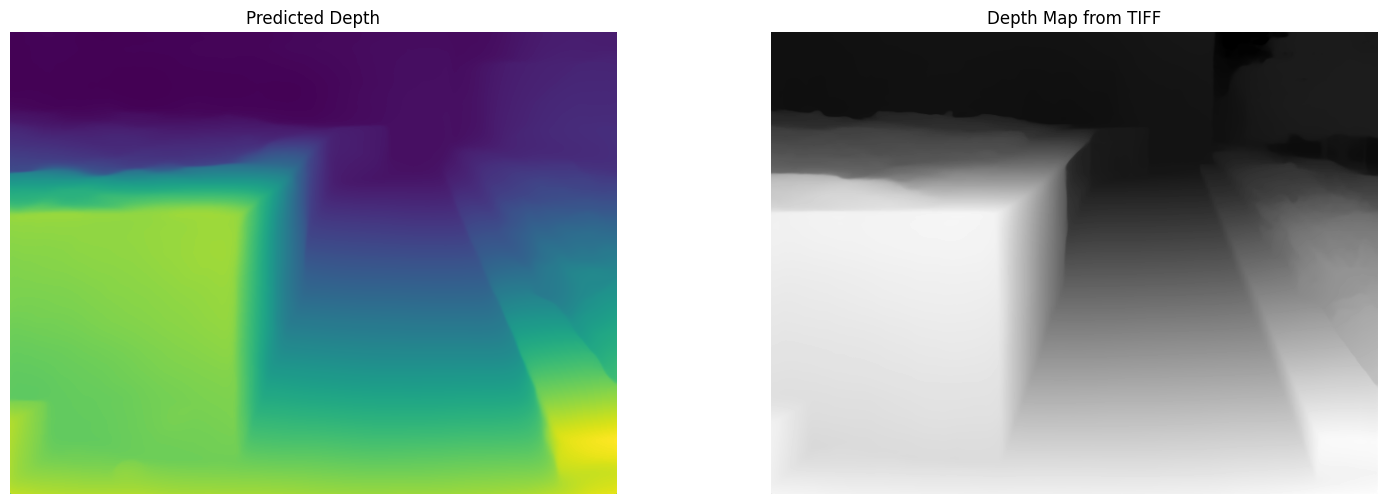

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def visualize_tiff(tiff_path):
    # Open the TIFF image using PIL
    img = Image.open(tiff_path)

    # Convert to numpy array
    img_array = np.array(img)

    # Normalize the image using min-max normalization
    img_normalized = min_max_normalize(img_array)

    return img_normalized

# Load the original image and predict depth
original_image = Image.open('/content/atlantis/img_sorted/07/00022_00193_outdoor_000_000_07.png')
inputs = image_processor(images=original_image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Interpolate to original size and convert to numpy array
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=original_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
depth_output = prediction.squeeze().cpu().numpy()

# Visualize the TIFF image and predicted depth side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


# Plot depth output and label it
axes[0].imshow(depth_output)
axes[0].set_title('Predicted Depth')
axes[0].axis('off')

# Visualize the TIFF image and label it
tiff_path = '/content/atlantis/depth/00022_00193_outdoor_000_000.png'
tiff_img_normalized = visualize_tiff(tiff_path)
axes[1].imshow(tiff_img_normalized, cmap='gray')
axes[1].set_title('Depth Map from TIFF')
axes[1].axis('off')

plt.show()

In [85]:
def reduce_outliers_normalize(image):
    # Get the 5th and 95th percentiles
    bottom_percentile = np.percentile(image, 5)
    top_percentile = np.percentile(image, 95)

    # Clip the pixel values to the 5th and 95th percentiles
    clipped_image = np.clip(image, bottom_percentile, top_percentile)

    # Get the minimum and maximum pixel values after clipping
    min_val = np.min(clipped_image)
    max_val = np.max(clipped_image)

    # Normalize the clipped image
    normalized_image = (clipped_image - min_val) / (max_val - min_val)
    return normalized_image

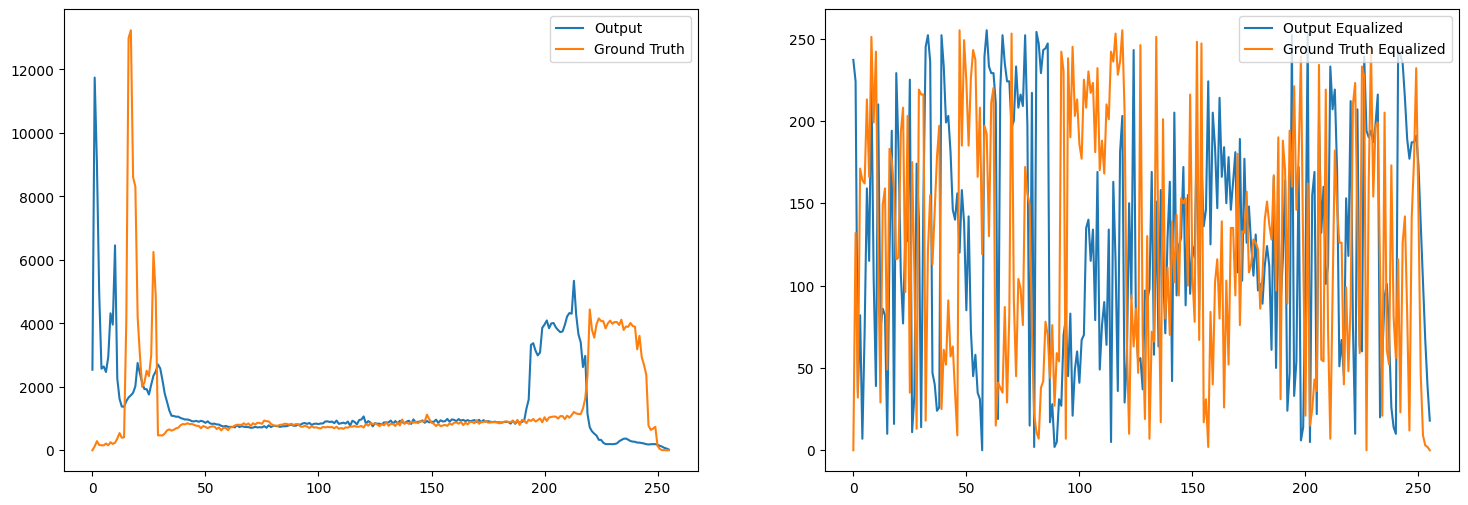

In [86]:
img_tiff = Image.open('/content/atlantis/depth/00022_00193_outdoor_000_000.png')
img_array_tiff = np.array(img_tiff)
img_normalized_tiff = min_max_normalize(img_array_tiff)

non_zero_mask = img_array_tiff != 0

# plt.hist(depth_output.ravel(),bins = 200,histtype='step', label= 'Output')
# plt.hist(img_array_tiff[non_zero_mask].ravel(),bins = 200, histtype='step',label = 'Ground Truth')

histr1 = cv2.calcHist([min_max_normalize(depth_output).astype(np.float32)],[0],None,[256],[0,1])
histr2 = cv2.calcHist([img_normalized_tiff[non_zero_mask].astype(np.float32)],[0],None,[256],[0,1])

eq_hist1 = cv2.equalizeHist(histr1.astype(np.uint8))
eq_hist2 = cv2.equalizeHist(histr2.astype(np.uint8))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(histr1,label= 'Output')
plt.plot(histr2,label = 'Ground Truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eq_hist1,label= 'Output Equalized')
plt.plot(eq_hist2,label = 'Ground Truth Equalized')
plt.legend()
_ = plt.show()

134.7100039016323
8.672534
126.03746991267965


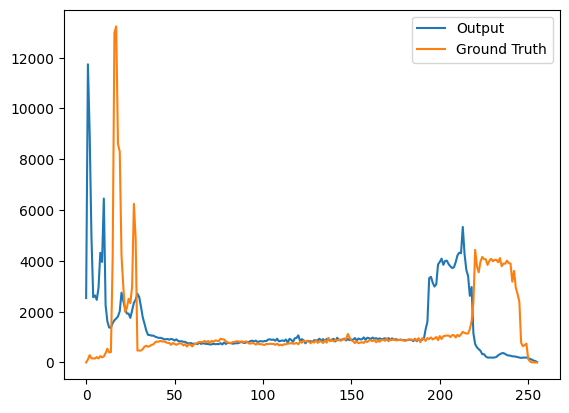

In [87]:
def scale_offset_invariance(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    print(mean1)
    print(mean2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - mean2

    print(offset)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset

    return depth_map2_adjusted

scale_offset_invariance_depth_output = scale_offset_invariance(img_array_tiff[non_zero_mask], depth_output)

histr1_inv = cv2.calcHist([scale_offset_invariance_depth_output],[0],None,[256],[0,1])
histr2 = cv2.calcHist([img_normalized_tiff[non_zero_mask].astype(np.float32)],[0],None,[256],[0,1])


plt.plot(histr1,label= 'Output')
plt.plot(histr2,label = 'Ground Truth')
plt.legend()

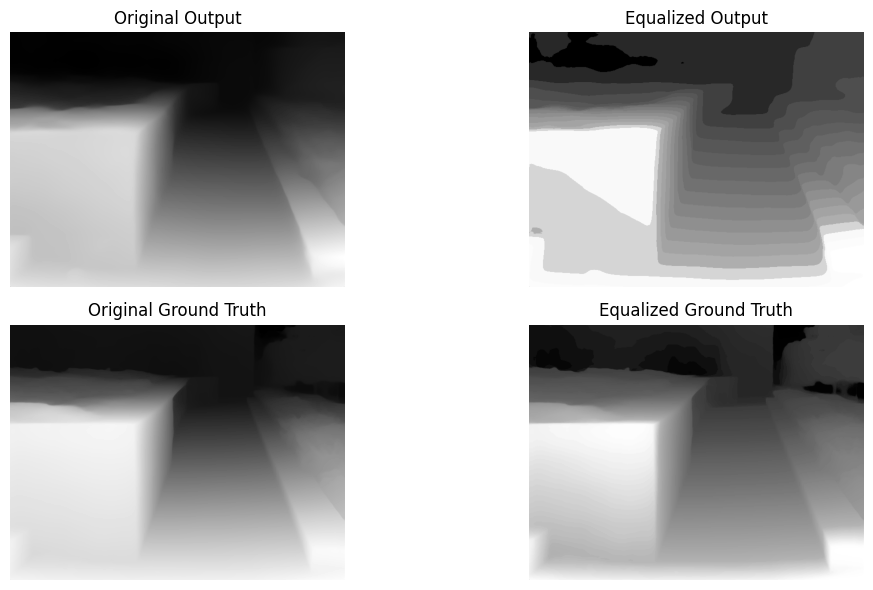

In [88]:
img_tiff = Image.open('/content/atlantis/depth/00022_00193_outdoor_000_000.png')
img_array_tiff = np.array(img_tiff)
img_normalized_tiff = min_max_normalize(img_array_tiff)

# Apply histogram equalization to both images
equalized_depth_output = cv2.equalizeHist(depth_output.astype(np.uint8))
equalized_ground_truth = cv2.equalizeHist(img_array_tiff.astype(np.uint8))

non_zero_mask = img_array_tiff != 0

# Calculate histograms
histr1 = cv2.calcHist([equalized_depth_output],[0],None,[256],[0,20])
histr2 = cv2.calcHist([equalized_ground_truth[non_zero_mask].astype(np.float32)],[0],None,[256],[0,20])

# Plotting
plt.figure(figsize=(12, 6))

# Original and equalized output image
plt.subplot(2, 2, 1)
plt.imshow(depth_output, cmap='gray')
plt.title('Original Output')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(equalized_depth_output, cmap='gray')
plt.title('Equalized Output')
plt.axis('off')

# Original and equalized ground truth image
plt.subplot(2, 2, 3)
plt.imshow(img_array_tiff, cmap='gray')
plt.title('Original Ground Truth')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(equalized_ground_truth, cmap='gray')
plt.title('Equalized Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()


In [89]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def scale_offset_invariance_psnr(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - (scale_factor * mean2)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset


    #Calculate the PSNR
    psnr_val = psnr(depth_map1, depth_map2_adjusted)

    return psnr_val


def scale_offset_invariance_ssim(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - (scale_factor * mean2)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset

    # Calculate the SSIM
    ssim_value, _ = ssim(depth_map1, depth_map2_adjusted, full=True)

    return ssim_value

In [90]:
import os
import random
import pandas as pd
import torch
import numpy as np
import scipy.stats
from PIL import Image

def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def calculate_metrics(directory_path, k, model, image_processor,lighting_type = '00'):
    results = []

    # Get a list of all files in the directory
    dir_path = os.path.join(directory_path, 'img_sorted',lighting_type)
    files = os.listdir(dir_path)
    # Filter out non-image files (assuming all images have extensions like .jpg, .png, etc.)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp','.tiff'))]

    # Load ground truth depth from TIFF file
    gt_depth_array = {}
    for img_file in image_files:
        res = img_file.split('_')
        res.pop()
        gt_tiff_file = '_'.join(res)
        gt_tiff_file += ".png"
        gt_tiff_path = os.path.join(directory_path, 'depth', gt_tiff_file)
        gt_depth_image = Image.open(gt_tiff_path)
        gt_depth_array[img_file] = np.array(gt_depth_image)

    # Shuffle the list of image files
    random.shuffle(image_files)

    for i, img_file in enumerate(image_files[:k]):
        # Load the original image
        img_path = os.path.join(directory_path, 'img_sorted',lighting_type, img_file)
        assert os.path.exists(img_path)
        original_image = Image.open(img_path)

        # Prepare image for the model
        inputs = image_processor(images=original_image, return_tensors="pt")

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=original_image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )

        # Convert depth prediction to numpy array and resize to match ground truth depth map size
        depth_output = prediction.squeeze().cpu().numpy()
        gt_depth_normalized = min_max_normalize(gt_depth_array[img_file])
        depth_output_resized = np.array(Image.fromarray(depth_output).resize(gt_depth_normalized.shape[::-1]))

        # Handle invalid or unexpected depth values
        depth_output_resized[depth_output_resized <= 0] = 1e-7  # Replace negative or zero values with a small epsilon

        # Calculate metrics
        non_zero_mask = gt_depth_normalized != 0
        absrel = np.mean(np.abs(depth_output_resized[non_zero_mask] - gt_depth_normalized[non_zero_mask]) / gt_depth_normalized[non_zero_mask])

        d = np.log(gt_depth_normalized + 1e-7) - np.log(depth_output_resized + 1e-7)
        silog = np.mean(np.square(d)) - np.square(np.sum(d))/ np.square(d.size)
        pearson_corr = scipy.stats.pearsonr(depth_output_resized.flatten(), gt_depth_normalized.flatten())[0]
        #psnr_val = psnr(gt_depth_normalized, depth_output_resized, data_range=depth_output_resized.max() - depth_output_resized.min())
        #ssim_val = ssim(gt_depth_normalized, depth_output_resized, data_range=depth_output_resized.max() - depth_output_resized.min())

        psnr_val = scale_offset_invariance_psnr(gt_depth_normalized,depth_output_resized)
        ssim_val = scale_offset_invariance_ssim(gt_depth_normalized,depth_output_resized)

        results.append({
            'Image': i,
            'Absolute Relative error (AbsRel)': absrel,
            'Scale Invarience MSE (Logscale)': silog,
            'Pearson Correlation': pearson_corr,
            'PSNR (Scale and offset Invarience)': psnr_val,
            'SSIM (Scale and offset Invarience)': ssim_val
        })

    return pd.DataFrame(results)


# Example usage:
# Replace '/content/D5' with the directory path containing your images and depth maps
metrics_df = calculate_metrics('/content/atlantis/', k=5, model=model, image_processor=image_processor,lighting_type = '07')
print(metrics_df)


<ipython-input-89-6fecb59e0444>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_val = psnr(depth_map1, depth_map2_adjusted)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


   Image  Absolute Relative error (AbsRel)  Scale Invarience MSE (Logscale)  \
0      0                          8.909842                        56.084541   
1      1                         17.763957                         8.918744   
2      2                         21.935719                         1.004061   
3      3                         22.611921                        24.672354   
4      4                         22.923417                         2.320024   

   Pearson Correlation  PSNR (Scale and offset Invarience)  \
0             0.991278                           24.174735   
1             0.970891                           23.785209   
2             0.994160                           29.892488   
3             0.976324                           22.476191   
4             0.992612                           27.327599   

   SSIM (Scale and offset Invarience)  
0                            0.648003  
1                            0.911155  
2                            0.9

In [91]:
#07 lighting condition
metrics_df

,Image,Absolute Relative error (AbsRel),Scale Invarience MSE (Logscale),Pearson Correlation,PSNR (Scale and offset Invarience),SSIM (Scale and offset Invarience)
0,0,8.909842,56.084541,0.991278,24.174735,0.648003
1,1,17.763957,8.918744,0.970891,23.785209,0.911155
2,2,21.935719,1.004061,0.994160,29.892488,0.952554
3,3,22.611921,24.672354,0.976324,22.476191,0.791489
4,4,22.923417,2.320024,0.992612,27.327599,0.957555
